# Current Source Density Analysis
Current source density analysis (CSD) is a method of analysis of extracellular electric potential measurments recorded at multiple sites which produces estimates of current sources generating the measured potentials. Here, it is applied to our Ecephys Local Field Potential (LFP) measurements along a neuropixel probe to visualize how activity moves through the brain over time. In this notebook, we use **[Elephant](https://elephant.readthedocs.io/)**, an Electrophysiology Library.

### Environment Setup

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import quantities as pq

from dandi import dandiapi
from elephant.current_source_density import generate_lfp, estimate_csd
from neo import AnalogSignal
from pynwb import NWBHDF5IO

### Downloading Ecephys File
For our data, we separate the LFP data for each probe into their own files since they are so large. The example file we use is from the Allen Institute's **Visual Coding - Neuropixels** dataset. To specify your own file to use, set `dandiset_id` and `dandi_filepath` to be the respective dandiset id and dandi filepath of the file you're interested in. When accessing an embargoed dataset, change `authenticate` to True and set `dandi_api_key` to be your DANDI API key.

In [5]:
dandiset_id = "000021"
dandi_filepath = "sub-699733573/sub-699733573_ses-715093703_probe-810755797_ecephys.nwb"
download_loc = "."

authenticate = False
dandi_api_key = ""

In [7]:
if authenticate:
    client = dandiapi.DandiAPIClient(token=dandi_api_key)
else:
    client = dandiapi.DandiAPIClient()
my_dandiset = client.get_dandiset(dandiset_id)

filename = dandi_filepath.split("/")[-1]
filepath = f"{download_loc}/{filename}"
file = my_dandiset.get_asset_by_path(dandi_filepath)

In [8]:
# # this may take awhile, especially if the file to download is large
file.download(filepath)

print(f"Downloaded file to {filepath}")

Downloaded file to ./sub-699733573_ses-715093703_probe-810755797_ecephys.nwb


In [9]:
io = NWBHDF5IO(filepath, mode="r", load_namespaces=True)
nwb = io.read()

C:\Users\carter.peene\AppData\Roaming\Python\Python39\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Roaming\Python\Python39\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Extracting Data
Here, we extract the LFP data from this file's probe data section. The `LFP` object contains a `data` array and a `timestamps` array which will be used.

In [17]:
lfp = nwb.acquisition["probe_810755797_lfp_data"]
lfp

probe_810755797_lfp_data pynwb.ecephys.ElectricalSeries at 0x1838087887840
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (10715666, 93), type "<f4">
  description: no description
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (10715666,), type "<f8">
  timestamps_unit: seconds
  unit: volts

### Selecting a Period
Oftentimes, the LFP data can be very large. Depending on the machine this analysis is performed on, there may not be enough memory to perform the current source density estimation. So it can be performed on some smaller period of time within the LFP data. If you wish to do this, set `period_start` and `period_end` to be reasonable times (in seconds) within the experiment to look at. Below are printed the first and last timestamps from the stimulus data and LFP data to inform this choice. It is recommended to choose a time selection of less than a second

In [18]:
print(lfp.timestamps[0])
print(lfp.timestamps[-1])

28.82399658853398
9616.024894403303


In [19]:
# period_start = lfp.timestamps[0]
period_start = 5000
# period_end = lfp.timestamps[-1]
period_end = 5001

In [20]:
# find indices within lfp data that correspond to period bounds
period_start_idx, period_end_idx = None, None
for i, ts in enumerate(lfp.timestamps):
    if not period_start_idx and ts >= period_start:
        period_start_idx = i
    if period_start_idx and ts >= period_end:
        period_end_idx = i
        break

if period_start_idx == None or period_end_idx == None:
    raise ValueError("Period bounds not found within lfp data")

# get slice of LFP data corresponding to the period bounds
lfp_timestamps = lfp.timestamps[period_start_idx:period_end_idx]
lfp_data = lfp.data[period_start_idx:period_end_idx]

In [21]:
print(lfp_timestamps.shape)
print(lfp_data.shape)

(1250,)
(1250, 93)


### Downsampling the Data
As mentioned above, the LFP data is at a very high recording rate. Even 1 second of data may have thousands of values. For speedier analysis, it is recommended that you select a smaller number of samples from the period you selected. Below, the data is downsampled by a factor of 4.

In [22]:
downsample_factor = 4

In [23]:
lfp_data = lfp_data[::downsample_factor]
lfp_timestamps = lfp_timestamps[::downsample_factor]

### Using Elephant to Estimate CSD
**Elephant** takes input in the form of a **Neo** *AnalogSignal*. Before analysis, we create the *AnalogSignal* object with a `hz` value calculated for the `sampling_rate` and a list of numbers, `coords` representing the channels of the LFP data. After this, it is as simple as calling `estimate_csd`.

In [24]:
hz = len(lfp_data) / (lfp_timestamps[-1] - lfp_timestamps[0])
coords = [(elem,) for elem in range(lfp_data.shape[1])]

neo_lfp = AnalogSignal(lfp_data, units="V", sampling_rate = hz*pq.Hz)
neo_lfp.annotate(coordinates = coords * pq.mm)

In [25]:
# this takes quite a while
csd = np.array(estimate_csd(neo_lfp, method="KCSD1D"))

No lambda given, using defaults
Cross validating R (all lambda) : 0.23
R, lambda : 0.23 0.00012115276586285876


### Displaying Current Source Density
The current source density over time can be shown below with **matplotlib's** `imshow` method. It can be seen that the y-axis contains 100 values. This is because **Elephant** spatially interpolates the input data to a length of 100.

Text(0, 0.5, 'Distance along probe (%)')

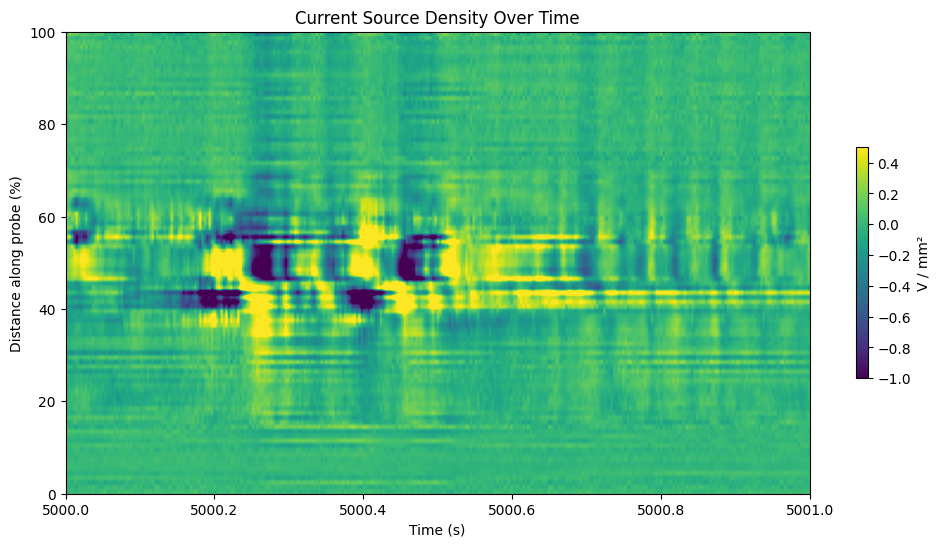

In [39]:
fig, ax = plt.subplots(figsize=(12,6))
img = ax.imshow(csd.transpose(), 
                extent=[period_start, period_end, 0, csd.shape[1]],
                aspect="auto",
                vmax=0.5,
                vmin=-1) # adjust vmin and vmax for your plot
cbar = fig.colorbar(img, shrink=0.5)
cbar.set_label("V / mm²")

ax.set_title("Current Source Density Over Time")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Distance along probe (%)")